# Reuse Knowledge with Transfer Learning

Remember, we didn't do well in terms of accuracy in our earlier experiment. For these experiments, we designed our models. Perhaps, our models were too small or our training data is insufficient for the model to identify patterns. This is a common problem in deep learning. Luckily, we have a solution which repurposes the models trained on extensive data. This technique is called Transfer Learning. It involves finetuning the pretrained models with our training data. We'll discuss it in this notebook. Below is the breakdown of this notebook:

- [Data Procurement](#data-procurement)
- [Create DataLoaders](#create-datasets-and-dataloaders)
- [Model Design](#model-design)
- [Training](#training)
- [Evaluation](#making-predictions-on-test-set)

We'll follow the [PyTorch Going Modular](https://www.learnpytorch.io/06_pytorch_transfer_learning/) tutorial by [@mrdbourke](https://github.com/mrdbourke/pytorch-deep-learning)

# Import Modules

In [4]:
import random
import torch
import torchvision
import torchinfo

from toolbox import data_setup, engine, utils
from torchinfo import summary as model_summary
from timeit import default_timer as timer 
from pathlib import Path
from PIL import Image

print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')
print(f'torchinfo version: {torchinfo.__version__}')

torch version: 2.1.0.dev20230608
torchvision version: 0.16.0.dev20230608
torchinfo version: 1.8.0


# Device Selection

In [5]:
DEVICE = utils.get_device()

# Data Procurement

We will download the [Food101](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip) dataset.

In [6]:
import os
import requests
import zipfile

# 1. Setup path to data folder
data_path = Path(os.path.expanduser("~/.datasets/"))
image_path = data_path / "pizza_steak_sushi"
train_path = image_path / 'train'
test_path = image_path / 'test'

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # 2. Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # 3. Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

/Users/broxoli/.datasets/pizza_steak_sushi directory exists.


# Create Datasets and DataLoaders

Steps:
1. Setup Hyperparameters
2. Choose a pretrained model for weights.
3. Load transforms from the pretrained model.
4. Initialize Dataloaders.

## Hyperparameters

In [7]:
BATCH_SIZE = 32

## Choose a Pretrained Model

In [8]:
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights = torchvision.models.ResNet50_Weights.DEFAULT

print(f'Pretrained Weights: {weights}')

Pretrained Weights: ResNet50_Weights.IMAGENET1K_V2


## Load Transforms from the Pretrained Model

In [9]:
transform = weights.transforms()

print(f'Transform: {transform}')

Transform: ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## Initialize DataLoaders

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_path=train_path,
    test_path=test_path,
    transform=transform,
    batch_size=BATCH_SIZE
)

Training Set
------------
Dataset ImageFolder
    Number of datapoints: 225
    Root location: /Users/broxoli/.datasets/pizza_steak_sushi/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}

Test Set
------------
Dataset ImageFolder
    Number of datapoints: 75
    Root location: /Users/broxoli/.datasets/pizza_steak_sushi/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Classes: ['pizza', 'steak', 'sushi']
Class Dictionary: {'pizza': 0, 'steak': 1, 'sush

# Model Design

Steps:

1. Choose a pretrained model.
2. 

## Explore Pretrained Model

In [107]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)

model_summary(
    model=model, 
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

## Freeze Pretrained Model

In [108]:
# Freeze all weights except the last two layers
for m in list(model.children())[:-2]:
    for p in m.parameters():
        p.requires_grad = False

model_summary(
    model=model, 
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

## Attach a Classification Head to the Pretrained Model

In [109]:
# 1. Set random seed
torch.manual_seed(3)
torch.cuda.manual_seed(3)

# 2. Get the size of the classification head
output_shape = len(class_names)

# Create a classification head
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(
        in_features=2048, 
        out_features=output_shape,
        bias=True
    )
).to(DEVICE)

model_summary(
    model=model, 
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

# Training

## Hyperparameters

In [110]:
LEARNING_RATE = 0.001
EPOCHS = 5

## Loss Function and Optimizer

In [111]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=LEARNING_RATE, params=model.parameters())

## Loop

In [113]:
print('Training Loop')
print('-------------')
print('-------------')

start_time = timer()

results = engine.train(
    model=model.to(DEVICE),
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    accuracy_fn=utils.accuracy_fn,
    epochs=EPOCHS,
    device=DEVICE
)

end_time = timer()

print(f"Total training time: {end_time - start_time:.3f} seconds")

Training Loop
-------------
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0376 | train_acc: 0.4609 | test_loss: 0.9905 | test_acc: 0.7633
Epoch: 2 | train_loss: 0.8517 | train_acc: 0.6836 | test_loss: 0.8776 | test_acc: 0.8049
Epoch: 3 | train_loss: 0.7538 | train_acc: 0.7773 | test_loss: 0.8142 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.6303 | train_acc: 0.9336 | test_loss: 0.7444 | test_acc: 0.9489
Epoch: 5 | train_loss: 0.5684 | train_acc: 0.9258 | test_loss: 0.6858 | test_acc: 0.9583
Total training time: 330.369 seconds


# Evaluate Model

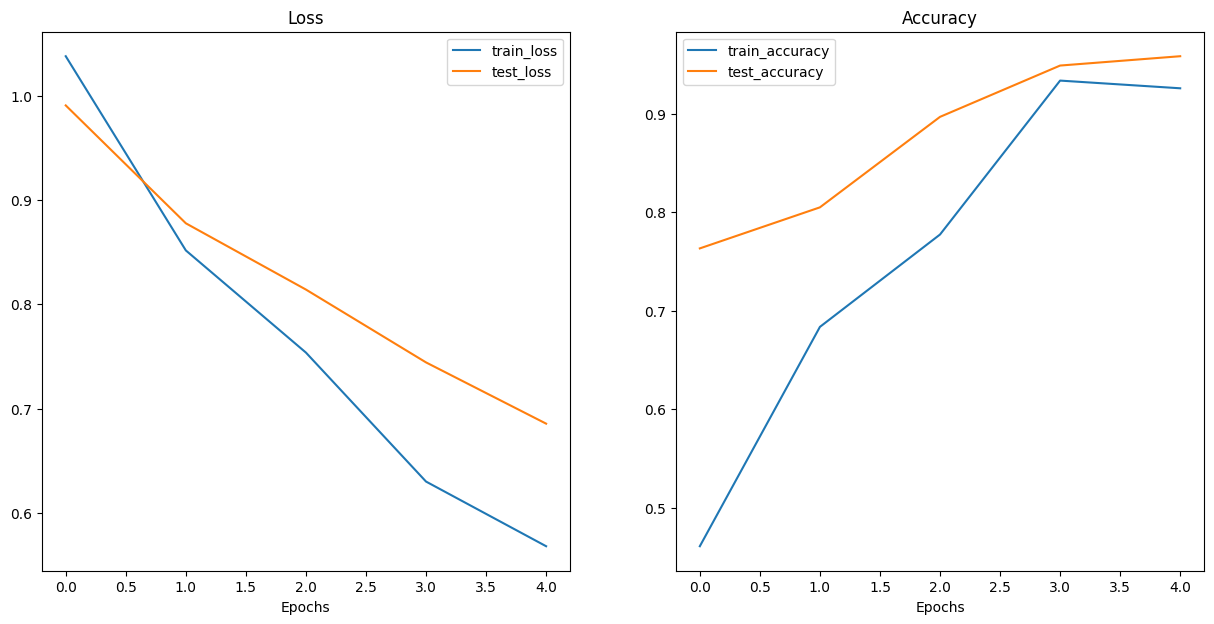

In [116]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# Making Predictions on Test Set

## Prediction Function

In [126]:
from typing import List, Tuple
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: str = DEVICE):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

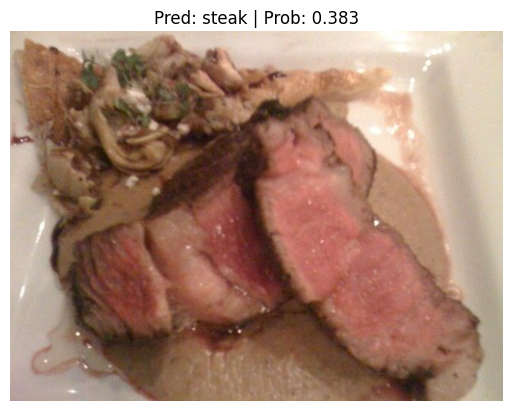

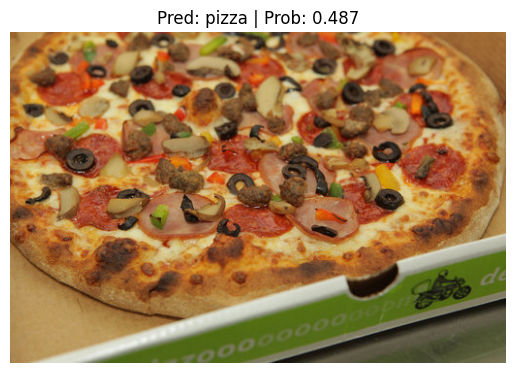

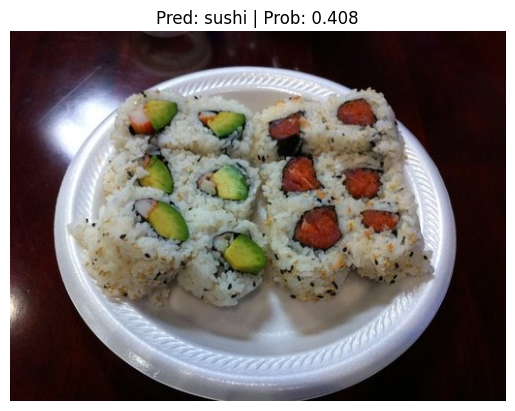

In [127]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_path).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))